# Harrow-Hassidim-Lloyd (HHL) Algorithm

This notebook demonstrates the **HHL algorithm** for solving systems of linear equations $A\vec{x} = \vec{b}$ on a quantum computer using the Amazon Braket SDK.

The HHL algorithm, introduced by Aram Harrow, Avinatan Hassidim, and Seth Lloyd in 2009 [1], is one of the fundamental quantum algorithms alongside Shor's factoring algorithm and Grover's search algorithm. It can provide an **exponential speedup** over classical methods for certain classes of problems.

## Overview

Given an $N \times N$ Hermitian matrix $A$ and a unit vector $\vec{b}$, the HHL algorithm prepares a quantum state $|x\rangle$ whose amplitudes are proportional to the entries of $\vec{x} = A^{-1}\vec{b}$. The algorithm cannot efficiently output the full solution vector $\vec{x}$ directly, but allows one to efficiently estimate summary statistics such as $\vec{x}^T M \vec{x}$ for some operator $M$.

### Algorithm Steps

The HHL algorithm consists of four main steps:

1. **State Preparation**: Encode the vector $\vec{b}$ into a quantum state $|b\rangle$
2. **Quantum Phase Estimation (QPE)**: Decompose $|b\rangle$ in the eigenbasis of $A$ and estimate the eigenvalues $\lambda_j$
3. **Controlled Rotation**: Apply a rotation conditioned on each eigenvalue to encode $C/\lambda_j$ into an ancilla qubit
4. **Inverse QPE**: Uncompute the eigenvalue register

After post-selecting on the ancilla qubit measuring $|1\rangle$, the remaining state is proportional to:

$$|x\rangle = A^{-1}|b\rangle = \sum_{j=1}^{N} \beta_j \lambda_j^{-1} |u_j\rangle$$

where $|u_j\rangle$ are the eigenvectors of $A$ and $\beta_j$ are the coefficients of $|b\rangle$ in the eigenbasis.

### Complexity

For sparse, well-conditioned matrices, HHL runs in $O(\log(N) \kappa^2)$ time, where $\kappa$ is the condition number of $A$. This is an exponential speedup compared to the best classical algorithm, which runs in $O(N\kappa)$.

### Caveats

- $A$ must be Hermitian (if not, it can be embedded in a larger Hermitian system)
- $\vec{b}$ must be efficiently preparable as a quantum state
- The exponential speedup only applies when summary statistics of $\vec{x}$ are needed, not the full solution
- The matrix should be sparse and well-conditioned for optimal performance

## References

[[1] A. W. Harrow, A. Hassidim, S. Lloyd, "Quantum algorithm for linear systems of equations", Phys. Rev. Lett. 103, 150502 (2009)](https://arxiv.org/abs/0811.3171)

[[2] Wikipedia: HHL Algorithm](https://en.wikipedia.org/wiki/HHL_algorithm)

[[3] S. Barz et al., "A two-qubit photonic quantum processor and its application to solving systems of linear equations", Scientific Reports 4, 6115 (2014)](https://arxiv.org/abs/1302.1210)

[[4] X.-D. Cai et al., "Experimental Quantum Computing to Solve Systems of Linear Equations", Phys. Rev. Lett. 110, 230501 (2013)](https://arxiv.org/abs/1302.4310)

[[5] J. Pan et al., "Experimental realization of quantum algorithm for solving linear systems of equations", Phys. Rev. A 89, 022313 (2014)](https://arxiv.org/abs/1302.1946)

## Setup

First, let's import the necessary libraries and the HHL module from the Braket Algorithm Library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from braket.circuits import Circuit
from braket.devices import LocalSimulator

from braket.experimental.algorithms.hhl import (
    hhl_circuit,
    run_hhl,
    get_hhl_results,
)

# magic word for producing visualizations in notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Example 1: Solving a Simple Diagonal System

Let's start with a simple example. Consider the system $A\vec{x} = \vec{b}$ where:

$$A = \begin{pmatrix} 1 & 0 \\ 0 & 2 \end{pmatrix}, \quad \vec{b} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$

The classical solution is trivially $\vec{x} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$.

This diagonal case is instructive because the eigenvalues are simply the diagonal elements, making it easy to understand how QPE encodes them and how the controlled rotation inverts them.

In [2]:
# Define the system
A1 = np.array([[1, 0], [0, 2]], dtype=complex)
b1 = np.array([1, 0], dtype=complex)

# Print eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(A1)
print(f"Matrix A:\n{A1}")
print(f"Vector b: {b1}")
print(f"Eigenvalues of A: {eigenvalues}")
print(f"Condition number: {max(abs(eigenvalues)) / min(abs(eigenvalues)):.2f}")
print(f"\nClassical solution: {np.linalg.solve(A1, b1)}")

Matrix A:
[[1.+0.j 0.+0.j]
 [0.+0.j 2.+0.j]]
Vector b: [1.+0.j 0.+0.j]
Eigenvalues of A: [1. 2.]
Condition number: 2.00

Classical solution: [1.+0.j 0.+0.j]


### Build and Visualize the HHL Circuit

In [3]:
# Build the HHL circuit
hhl_circ1 = hhl_circuit(A1, b1, num_clock_qubits=2)

print("HHL Circuit for Example 1:")
print(f"Number of qubits: {hhl_circ1.qubit_count}")
print(f"  - Clock qubits: q0, q1 (QPE register)")
print(f"  - Input qubit: q2 (encodes |b>)")
print(f"  - Ancilla qubit: q3 (for eigenvalue inversion)")
print(f"Circuit depth: {hhl_circ1.depth}")
print(f"Number of instructions: {len(hhl_circ1.instructions)}")

HHL Circuit for Example 1:
Number of qubits: 4
  - Clock qubits: q0, q1 (QPE register)
  - Input qubit: q2 (encodes |b>)
  - Ancilla qubit: q3 (for eigenvalue inversion)
Circuit depth: 48
Number of instructions: 63


### Run on the Local Simulator

In [4]:
# Run on local simulator
device = LocalSimulator()
print("Running HHL Algorithm...")
task1 = run_hhl(hhl_circ1, device, shots=10000)
print("HHL Run Complete!")

# Get and display results
results1 = get_hhl_results(task1, A1, b1, num_clock_qubits=2, verbose=True)

Running HHL Algorithm...
HHL Run Complete!
Matrix A:
[[1.+0.j 0.+0.j]
 [0.+0.j 2.+0.j]]

Vector b: [1.+0.j 0.+0.j]

Classical solution x = A^(-1)b: [1.+0.j 0.+0.j]
Classical solution (normalized): [1.+0.j 0.+0.j]
Classical probabilities |x_i|^2: [1. 0.]

Total measurement shots: 10000
Post-selection success shots: 984
Success probability: 0.0984

Post-selected counts: {'0': 984}
Quantum solution probabilities: {'0': 1.0}

Fidelity with classical solution: 1.0000


### Visualize the Results

Let's compare the quantum solution (from post-selected measurements) with the classical solution.

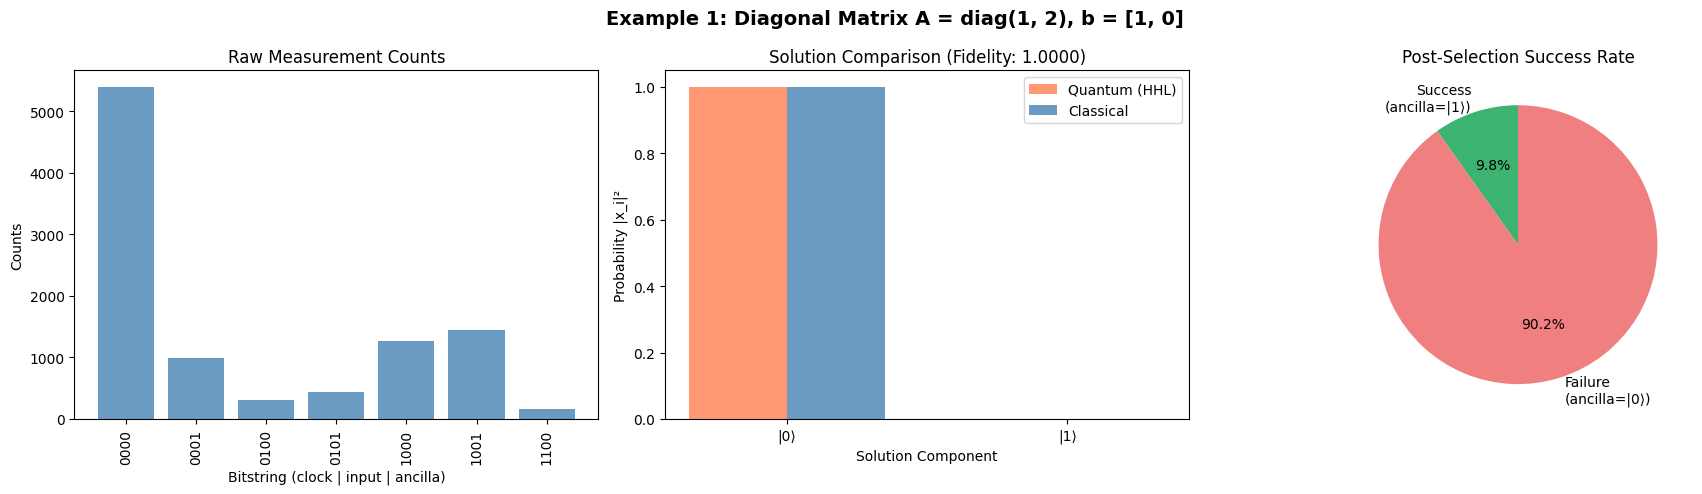

In [5]:
def plot_hhl_comparison(results, title="HHL Algorithm Results"):
    """Plot comparison between quantum and classical solutions."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Raw measurement counts
    counts = results["measurement_counts"]
    sorted_counts = dict(sorted(counts.items()))
    axes[0].bar(sorted_counts.keys(), sorted_counts.values(), color="steelblue", alpha=0.8)
    axes[0].set_xlabel("Bitstring (clock | input | ancilla)")
    axes[0].set_ylabel("Counts")
    axes[0].set_title("Raw Measurement Counts")
    axes[0].tick_params(axis="x", rotation=90)

    # Plot 2: Post-selected solution probabilities vs classical
    quantum_probs = [
        results["solution_state_probabilities"].get("0", 0),
        results["solution_state_probabilities"].get("1", 0),
    ]
    classical_probs = list(results["classical_probabilities"])

    x = np.arange(2)
    width = 0.35
    axes[1].bar(
        x - width / 2, quantum_probs, width, label="Quantum (HHL)", color="coral", alpha=0.8
    )
    axes[1].bar(
        x + width / 2, classical_probs, width, label="Classical", color="steelblue", alpha=0.8
    )
    axes[1].set_xlabel("Solution Component")
    axes[1].set_ylabel("Probability |x_i|²")
    axes[1].set_title(f"Solution Comparison (Fidelity: {results['fidelity']:.4f})")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(["|0⟩", "|1⟩"])
    axes[1].legend()

    # Plot 3: Success probability pie chart
    success_rate = results["success_probability"]
    axes[2].pie(
        [success_rate, 1 - success_rate],
        labels=["Success\n(ancilla=|1⟩)", "Failure\n(ancilla=|0⟩)"],
        colors=["mediumseagreen", "lightcoral"],
        autopct="%1.1f%%",
        startangle=90,
    )
    axes[2].set_title("Post-Selection Success Rate")

    fig.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


plot_hhl_comparison(results1, "Example 1: Diagonal Matrix A = diag(1, 2), b = [1, 0]")

## Example 2: Solving a Non-Diagonal Hermitian System

Now let's try a more interesting example with off-diagonal elements:

$$A = \begin{pmatrix} 2 & 1 \\ 1 & 2 \end{pmatrix}, \quad \vec{b} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$$

This matrix has eigenvalues $\lambda_1 = 1$ and $\lambda_2 = 3$, with condition number $\kappa = 3$.

The classical solution is:
$$\vec{x} = A^{-1}\vec{b} = \frac{1}{3\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$$

In [6]:
# Define the system
A2 = np.array([[2, 1], [1, 2]], dtype=complex)
b2 = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)], dtype=complex)

# Print eigenvalues
eigenvalues2, eigenvectors2 = np.linalg.eigh(A2)
print(f"Matrix A:\n{A2}")
print(f"Vector b: {b2}")
print(f"Eigenvalues of A: {eigenvalues2}")
print(f"Condition number: {max(abs(eigenvalues2)) / min(abs(eigenvalues2)):.2f}")
print(f"\nClassical solution: {np.linalg.solve(A2, b2)}")

Matrix A:
[[2.+0.j 1.+0.j]
 [1.+0.j 2.+0.j]]
Vector b: [0.70710678+0.j 0.70710678+0.j]
Eigenvalues of A: [1. 3.]
Condition number: 3.00

Classical solution: [0.23570226+0.j 0.23570226+0.j]


Running HHL Algorithm for Example 2...
HHL Run Complete!
Matrix A:
[[2.+0.j 1.+0.j]
 [1.+0.j 2.+0.j]]

Vector b: [0.70710678+0.j 0.70710678+0.j]

Classical solution x = A^(-1)b: [0.23570226+0.j 0.23570226+0.j]
Classical solution (normalized): [0.70710678+0.j 0.70710678+0.j]
Classical probabilities |x_i|^2: [0.5 0.5]

Total measurement shots: 10000
Post-selection success shots: 7312
Success probability: 0.7312

Post-selected counts: {'1': 3733, '0': 3579}
Quantum solution probabilities: {'1': 0.5105306345733042, '0': 0.48946936542669583}

Fidelity with classical solution: 0.9999


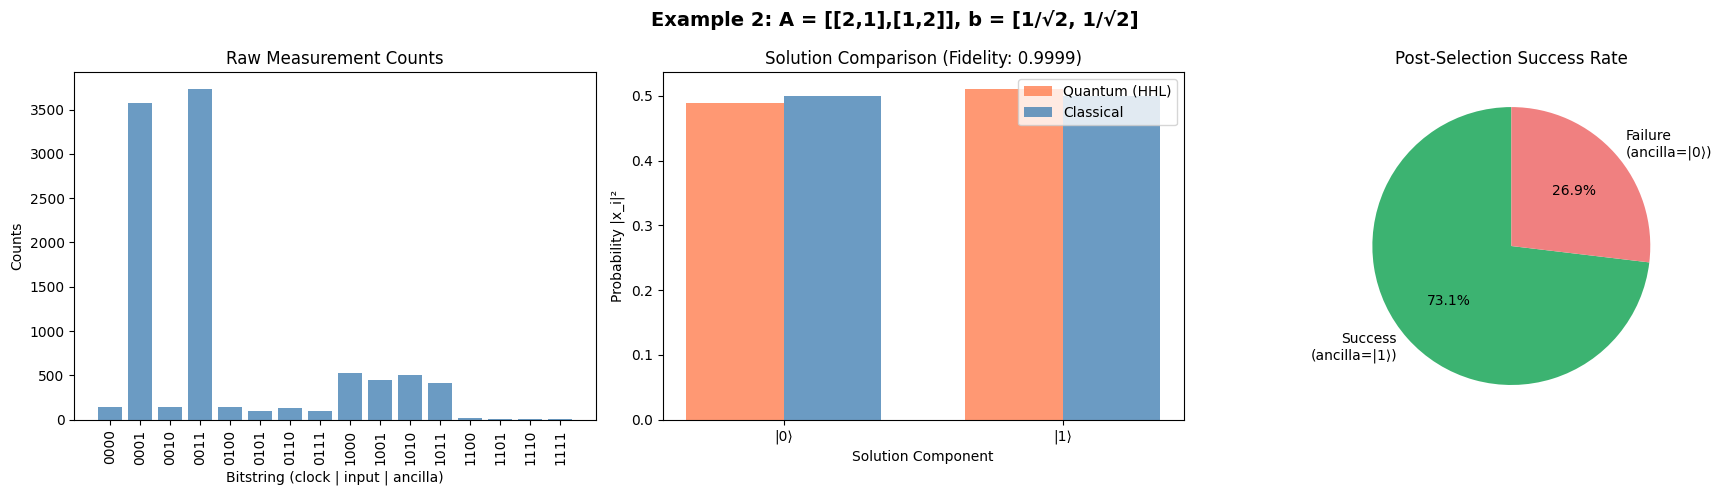

In [7]:
# Build and run HHL
hhl_circ2 = hhl_circuit(A2, b2, num_clock_qubits=2)

print("Running HHL Algorithm for Example 2...")
task2 = run_hhl(hhl_circ2, device, shots=10000)
print("HHL Run Complete!")

results2 = get_hhl_results(task2, A2, b2, num_clock_qubits=2, verbose=True)

plot_hhl_comparison(results2, "Example 2: A = [[2,1],[1,2]], b = [1/√2, 1/√2]")

## Example 3: Effect of the Condition Number

The condition number $\kappa = \lambda_{\max}/\lambda_{\min}$ is a key parameter affecting HHL performance.
Let's explore how different condition numbers affect the success probability and solution quality.

We'll use the matrix:
$$A = \begin{pmatrix} \lambda_1 & 0 \\ 0 & \lambda_2 \end{pmatrix}$$

with $\lambda_1 = 1$ and varying $\lambda_2$ to change the condition number.

Condition Number Analysis
κ = 1: Fidelity = 0.9999, Success Prob = 0.8049
κ = 2: Fidelity = 0.5256, Success Prob = 0.4306
κ = 3: Fidelity = 0.2032, Success Prob = 0.3694
κ = 4: Fidelity = 0.1002, Success Prob = 0.2024


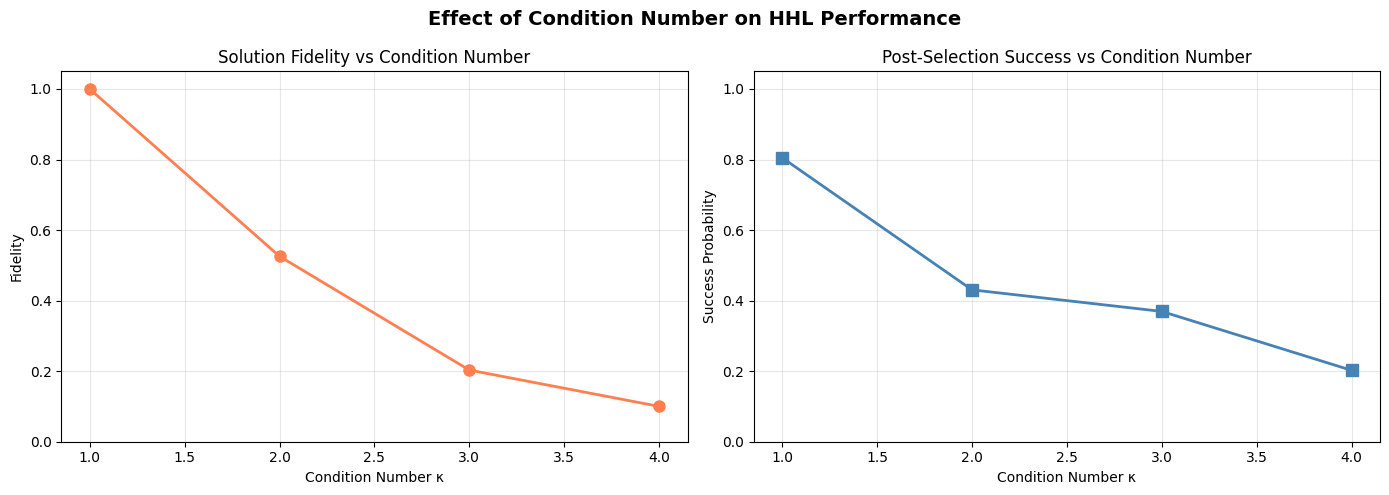

In [8]:
# Test with different condition numbers
b_test = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)], dtype=complex)
condition_numbers = [1, 2, 3, 4]
fidelities = []
success_probs = []

print("Condition Number Analysis")
print("=" * 60)

for kappa in condition_numbers:
    A_test = np.array([[1, 0], [0, kappa]], dtype=complex)
    circ = hhl_circuit(A_test, b_test, num_clock_qubits=2)
    task = run_hhl(circ, device, shots=10000)
    results = get_hhl_results(task, A_test, b_test, num_clock_qubits=2)

    fidelities.append(results["fidelity"])
    success_probs.append(results["success_probability"])

    print(
        f"κ = {kappa}: Fidelity = {results['fidelity']:.4f}, "
        f"Success Prob = {results['success_probability']:.4f}"
    )

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(condition_numbers, fidelities, "o-", color="coral", linewidth=2, markersize=8)
ax1.set_xlabel("Condition Number κ")
ax1.set_ylabel("Fidelity")
ax1.set_title("Solution Fidelity vs Condition Number")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

ax2.plot(condition_numbers, success_probs, "s-", color="steelblue", linewidth=2, markersize=8)
ax2.set_xlabel("Condition Number κ")
ax2.set_ylabel("Success Probability")
ax2.set_title("Post-Selection Success vs Condition Number")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

plt.suptitle("Effect of Condition Number on HHL Performance", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Understanding the Circuit Components

Let's walk through each component of the HHL circuit in more detail.

### 1. State Preparation

The vector $\vec{b}$ is encoded as a quantum state $|b\rangle$ on the input qubit. For a 2-element vector $\vec{b} = (b_0, b_1)^T$, this is done using an $R_y$ rotation:

$$|b\rangle = \cos(\theta/2)|0\rangle + \sin(\theta/2)|1\rangle$$

where $\theta = 2\arccos(b_0)$ for real vectors.

### 2. Quantum Phase Estimation (QPE)

QPE decomposes $|b\rangle$ in the eigenbasis of $A$ and estimates eigenvalues. It uses:
- Hadamard gates on clock qubits to create superposition
- Controlled $U^{2^k} = e^{iAt \cdot 2^k}$ operations (Hamiltonian simulation)
- Inverse QFT on the clock register

After QPE, the state is approximately:
$$\sum_j \beta_j |u_j\rangle|\tilde{\lambda}_j\rangle$$

### 3. Controlled Rotation

For each eigenvalue $\lambda_j$ stored in the clock register, we perform a controlled $R_y$ rotation on the ancilla qubit with angle $\theta_j = 2\arcsin(C/\lambda_j)$:

$$|\tilde{\lambda}_j\rangle|0\rangle_a \rightarrow |\tilde{\lambda}_j\rangle\left(\sqrt{1 - \frac{C^2}{\lambda_j^2}}|0\rangle_a + \frac{C}{\lambda_j}|1\rangle_a\right)$$

### 4. Inverse QPE

The inverse QPE uncomputes the clock register, returning it to $|0\rangle^{\otimes n}$.
After post-selecting on the ancilla measuring $|1\rangle$, the input qubit is in the state $|x\rangle \propto A^{-1}|b\rangle$.

## Example 4: Varying the Input Vector

Let's fix the matrix and explore how different input vectors $\vec{b}$ affect the solution.

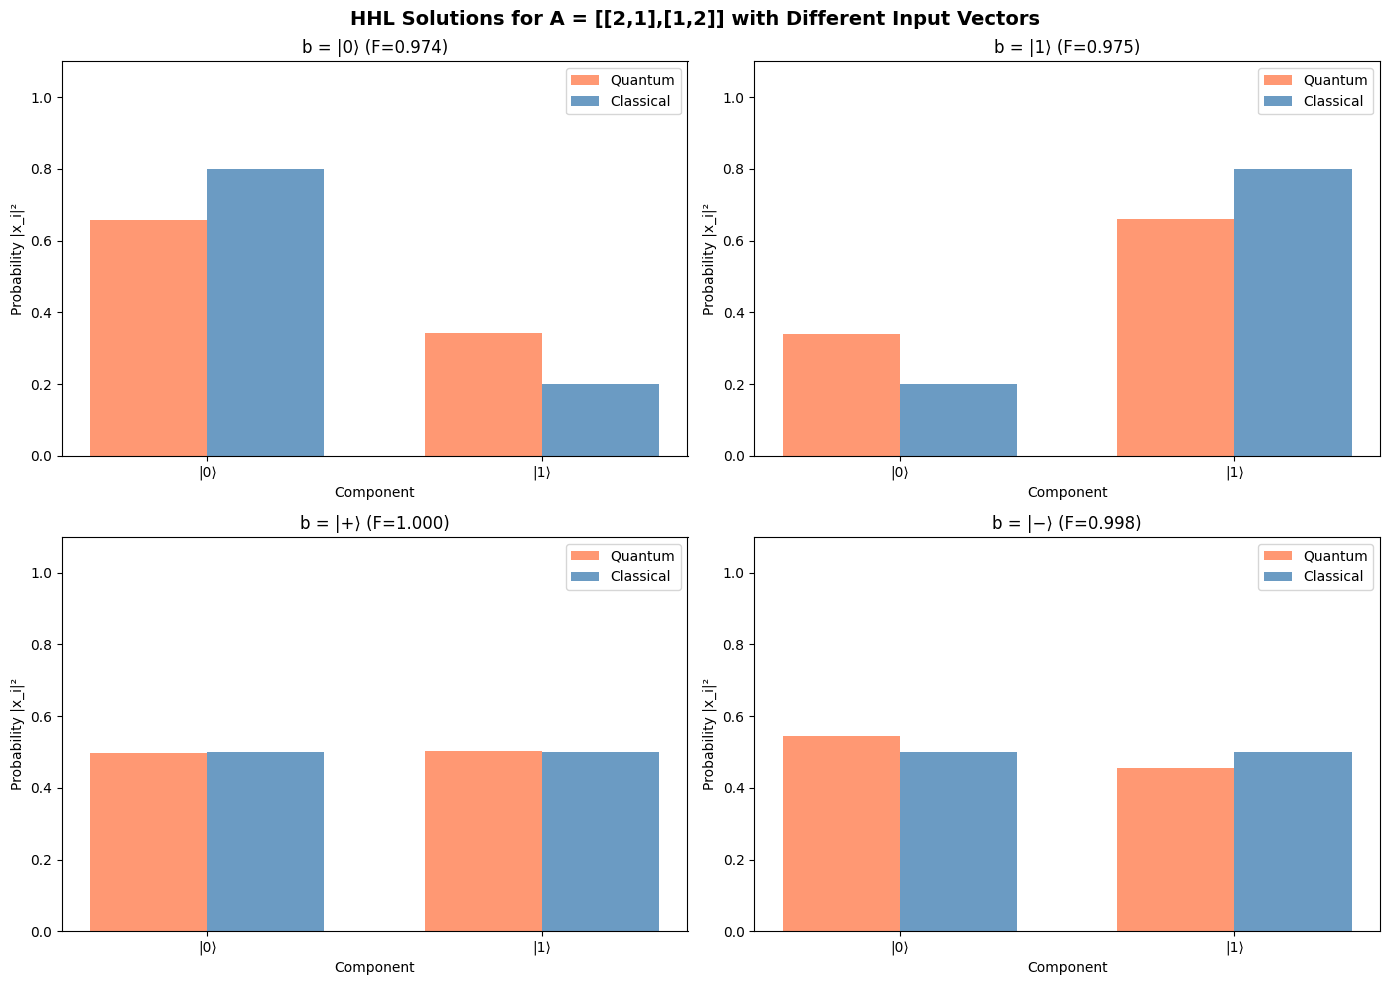

In [9]:
A4 = np.array([[2, 1], [1, 2]], dtype=complex)

# Different b vectors (all normalized)
test_vectors = [
    (np.array([1, 0], dtype=complex), "|0⟩"),
    (np.array([0, 1], dtype=complex), "|1⟩"),
    (np.array([1 / np.sqrt(2), 1 / np.sqrt(2)], dtype=complex), "|+⟩"),
    (np.array([1 / np.sqrt(2), -1 / np.sqrt(2)], dtype=complex), "|−⟩"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (b_vec, label) in enumerate(test_vectors):
    ax = axes[idx // 2][idx % 2]

    circ = hhl_circuit(A4, b_vec, num_clock_qubits=2)
    task = run_hhl(circ, device, shots=10000)
    results = get_hhl_results(task, A4, b_vec, num_clock_qubits=2)

    quantum_probs = [
        results["solution_state_probabilities"].get("0", 0),
        results["solution_state_probabilities"].get("1", 0),
    ]
    classical_probs = list(results["classical_probabilities"])

    x = np.arange(2)
    width = 0.35
    ax.bar(x - width / 2, quantum_probs, width, label="Quantum", color="coral", alpha=0.8)
    ax.bar(x + width / 2, classical_probs, width, label="Classical", color="steelblue", alpha=0.8)
    ax.set_xlabel("Component")
    ax.set_ylabel("Probability |x_i|²")
    ax.set_title(f"b = {label} (F={results['fidelity']:.3f})")
    ax.set_xticks(x)
    ax.set_xticklabels(["|0⟩", "|1⟩"])
    ax.legend()
    ax.set_ylim([0, 1.1])

plt.suptitle(
    "HHL Solutions for A = [[2,1],[1,2]] with Different Input Vectors",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

## Practical Considerations and Limitations

### When Does HHL Provide a Speedup?

The HHL algorithm provides an exponential speedup when:
1. The matrix $A$ is **sparse** (few non-zero entries per row)
2. The matrix is **well-conditioned** (small condition number $\kappa$)
3. Only **summary statistics** of the solution are needed (not the full vector)
4. The state $|b\rangle$ can be **efficiently prepared**

### Current Limitations

- **Qubit count**: For an $N \times N$ system, the algorithm requires $O(\log N)$ qubits for the input register plus additional qubits for QPE and ancilla
- **Circuit depth**: The QPE and Hamiltonian simulation steps can require deep circuits
- **Post-selection**: The success probability depends on the condition number, requiring $O(\kappa)$ repetitions
- **Noise**: Current NISQ devices have limited coherence times and gate fidelities

### Applications

Despite these limitations, HHL has been proposed for many applications:
- **Machine Learning**: Linear regression, support vector machines, principal component analysis
- **Computational Finance**: Portfolio optimization, options pricing via PDEs
- **Scientific Computing**: Solving differential equations, finite element methods
- **Quantum Chemistry**: Solving coupled cluster equations

## [Optional] Run on a QPU or Managed Simulator

The following cells demonstrate how to run the HHL algorithm on an Amazon Braket managed simulator or QPU.

Note: Running on a QPU will incur costs. Use the [Braket cost tracker](https://docs.aws.amazon.com/braket/latest/developerguide/braket-pricing.html#real-time-cost-tracking) to estimate costs.

In [10]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
# from braket.tracking import Tracker

# tracker = Tracker().start()

In [11]:
# from braket.aws import AwsDevice

# # Define the system
# A_qpu = np.array([[1, 0], [0, 2]], dtype=complex)
# b_qpu = np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)

# # Build the circuit
# hhl_circ_qpu = hhl_circuit(A_qpu, b_qpu, num_clock_qubits=2)

# # Run on managed simulator (uncomment the QPU line to run on a real device)
# # qpu = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2")
# managed_device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# print("Running HHL on managed simulator...")
# task_qpu = run_hhl(hhl_circ_qpu, managed_device, shots=10000)
# print("HHL Run Complete!")

# results_qpu = get_hhl_results(
#     task_qpu, A_qpu, b_qpu, num_clock_qubits=2, verbose=True
# )

# plot_hhl_comparison(results_qpu, "HHL on Managed Simulator")

In [12]:
# print("Task Summary")
# print(f"{tracker.quantum_tasks_statistics()} \n")
# print(
#     f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD"
# )

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).